In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 폴더 생성

In [2]:
!mkdir /content/all_use_model_dataset ## -----------변경

In [3]:
!mkdir /content/all_use_model_dataset/images  ## -----------변경
!mkdir /content/all_use_model_dataset/masks  ## -----------변경

In [4]:
!mkdir /content/all_use_model_dataset/masks/0  ## -----------변경
!mkdir /content/all_use_model_dataset/masks/1  ## -----------변경
!mkdir /content/all_use_model_dataset/masks/2  ## -----------변경
!mkdir /content/all_use_model_dataset/masks/3  ## -----------변경
!mkdir /content/all_use_model_dataset/masks/4  ## -----------변경

# mrcnn 불러오기

In [5]:
!mkdir /content/img_data

!mkdir /content/img_data/0
!mkdir /content/img_data/1
!mkdir /content/img_data/2
!mkdir /content/img_data/3

In [6]:
!gdown 1ynSi_HUzOGXTepJpQG6KnExKakDGjxQT ## mrcnn
!unzip /content/mrcnn.zip -d /content/mrcnn

Downloading...
From: https://drive.google.com/uc?id=1ynSi_HUzOGXTepJpQG6KnExKakDGjxQT
To: /content/mrcnn.zip
100% 54.5k/54.5k [00:00<00:00, 60.3MB/s]
Archive:  /content/mrcnn.zip
  inflating: /content/mrcnn/config.py  
 extracting: /content/mrcnn/__init__.py  
  inflating: /content/mrcnn/model.py  
  inflating: /content/mrcnn/parallel_model.py  
   creating: /content/mrcnn/__pycache__/
  inflating: /content/mrcnn/utils.py  
  inflating: /content/mrcnn/visualize.py  


# Dataset 불러오기

In [ ]:
!gdown 15qW965JVTWthkSEPI9n4wv5IHiAuHB6l ## data set  ## -----------변경
!unzip /content/coco_multilabel_220706.zip -d /content/img_data/0

In [ ]:
!gdown 1Zmutg1h83EhSq5OCt-yU2wVqBNEtRuBM ## data set  ## -----------변경
!unzip /content/규원_1_multilabel.zip -d /content/img_data/1

In [ ]:
!gdown 1tpnzjGpqUkeQJtKfJPX-NKq5xDLsWKJi ## data set  ## -----------변경
!unzip /content/규원_2_multilabel.zip -d /content/img_data/2

In [ ]:
!gdown 1e6lXvrinhfmT0CZ2biWgo77MgLNus5KJ ## data set  ## -----------변경
!unzip /content/handmade.zip -d /content/img_data/3

# 라이브러리 업데이트

In [11]:
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.3 MB/s 
     |████████████████████████████████| 3.2 MB 46.4 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 367 kB 74.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
ERROR: pip's dependency resolver does not currently ta

# Class 수정

In [36]:
import os
import json
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
import shutil

from mrcnn import model as modellib, utils

############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("part", 1, "scratch")
        self.add_class("part", 2, "dent")
        self.add_class("part", 3, "spacing")
        self.add_class("part", 4, "broken")

        # Train or validation dataset?
        assert subset in ["img"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open("/content/img_data/3/img/via_project_7Jul2022_11h8m.json")) ## -----------변경
        # print(annotations1)
        annotations = list(annotations['_via_img_metadata'].values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        #class_nums = {'rear_bumper': 1, 'front_bumper': 2, 'headlamp': 3, 'hood': 4, 'door': 5}

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            #for r in a['regions']:
                #polygons = [{'all_points_x': r['shape_attributes']['all_points_x'], 'all_points_y': r['shape_attributes']['all_points_y']}]
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes'] for s in a['regions']]
            #num_ids = [int(class_nums[n['name']]) for n in objects]
            num_ids = []
            for n in objects:
                try:
                    if n['class'] == 'scratch':
                        num_ids.append(1)
                    elif n['class'] == 'dent':
                        num_ids.append(2)
                    elif n['class'] == 'spacing':
                        num_ids.append(3)
                    elif n['class'] == 'broken':
                        num_ids.append(4)
                except:
                    pass
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "part",  # for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        # print("info['num_ids']=", info['num_ids'])
        # Map class names to class IDs.
        num_ids = info['num_ids']
        return mask.astype(np.bool), num_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "part":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# Mask dataset

In [37]:
dataset_DIR = '/content/img_data/3/'  ## -----------변경

In [38]:
dataset = CustomDataset()
dataset.load_custom(dataset_DIR, "img")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 111
Class Count: 5
  0. BG                                                
  1. scratch                                           
  2. dent                                              
  3. spacing                                           
  4. broken                                            


# Make mask dataset

In [39]:
img_path = '/content/all_use_model_dataset/' ## -----------변경
before_path = '/content/img_data/3/img/'
move_path = '/content/all_use_model_dataset/images/' ## -----------변경

In [40]:
classes = dataset.class_info

for i, data in enumerate(dataset.image_info): # image 기준 for문
    # width, height값 추출(mask좌표가 1024일 경우 index range out error발생, 임의로 1을 더해주어 에러 해결함)
    w = data['width'] + 1   
    h = data['height'] + 1

    data_id = int(data['id'].split('.')[0]) # 원본 img name만 뽑아냄(작업한 data_name이 숫자로 되어있음, 이후 파일 저장할 때 숫자로 저장하기 위해 int값을 줌)

    print('--------------------------', data_id, '--------------------------')
    
    id_list = []
    array_list = []

    for idx, (poly, ids) in enumerate(zip(data['polygons'], data['num_ids'])): # polygons 기준 for문
        # 원본 image size를 참고하여 그 크기 만큼 0으로만 채워진 array 행렬 생성
        zeros_mask = np.zeros([h, w])
        
        # CustomDataset에서 x, y 좌표 추출
        x = poly['all_points_x']
        y = poly['all_points_y']
        
        # 추출한 x, y값을 참고하여 mask부분의 채워진 좌표값 추출
        poly_x, poly_y = skimage.draw.polygon(x, y)
        
        # 각 image에 따른 mask label을 추출하여 id_list에 append
        id_list.append(classes[ids]['id'])
        
        # mask에 해당하는 좌표값을 1로 바꿔 줌
        for px, py in zip(poly_x, poly_y): # mask 좌표 기준 for문
            zeros_mask[py, px] = 1
        
        # mask가 1로 바뀐 array 행렬을 array_list에 append
        array_list.append(zeros_mask)

    # 각 mask label의 zero로 채워진 array 행렬 생성
    zero_zeros = np.zeros([h, w])
    one_zeros = np.zeros([h, w])
    two_zeros = np.zeros([h, w])
    three_zeros = np.zeros([h, w])
    four_zeros = np.zeros([h, w])

    # 각 mask label의 zero array에 mask로 채워진 array를 더해주어, 같은 label일 경우 합쳐주는 for문
    for id, array in zip(id_list, array_list):
        if id == 1: one_zeros += array
        elif id == 2: two_zeros += array
        elif id == 3: three_zeros += array
        elif id == 4: four_zeros += array

    # 원본 image 이동
    shutil.move(before_path + data['id'], move_path+f'/d_make_{data_id:03}.jpg')

    # mask image로 save 및 출력
    plt.imshow(zero_zeros)
    plt.show()
    plt.imsave(img_path+f'masks/0/d_make_{data_id:03}.jpg', zero_zeros, cmap = 'gray')  ## -----------변경
    
    plt.imshow(one_zeros)
    plt.show()
    plt.imsave(img_path+f'masks/1/d_make_{data_id:03}.jpg', one_zeros, cmap = 'gray')  ## -----------변경

    plt.imshow(two_zeros)
    plt.show()
    plt.imsave(img_path+f'masks/2/d_make_{data_id:03}.jpg', two_zeros, cmap = 'gray')  ## -----------변경

    plt.imshow(three_zeros)
    plt.show()
    plt.imsave(img_path+f'masks/3/d_make_{data_id:03}.jpg', three_zeros, cmap = 'gray')  ## -----------변경

    plt.imshow(four_zeros)
    plt.show()
    plt.imsave(img_path+f'masks/4/d_make_{data_id:03}.jpg', four_zeros, cmap = 'gray')  ## -----------변경

Output hidden; open in https://colab.research.google.com to view.

# Dataset zip

In [41]:
!pwd

/content


In [42]:
!zip -r all_handmade_dataset.zip ./all_handmade_dataset/  ## -----------변경

  adding: all_handmade_dataset/ (stored 0%)
  adding: all_handmade_dataset/masks/ (stored 0%)
  adding: all_handmade_dataset/masks/4/ (stored 0%)
  adding: all_handmade_dataset/masks/4/a_make_064.jpg (deflated 97%)
  adding: all_handmade_dataset/masks/4/b_make_028.jpg (deflated 94%)
  adding: all_handmade_dataset/masks/4/c_make_177.jpg (deflated 96%)
  adding: all_handmade_dataset/masks/4/c_make_196.jpg (deflated 51%)
  adding: all_handmade_dataset/masks/4/b_make_074.jpg (deflated 69%)
  adding: all_handmade_dataset/masks/4/a_make_001.jpg (deflated 97%)
  adding: all_handmade_dataset/masks/4/a_make_015.jpg (deflated 97%)
  adding: all_handmade_dataset/masks/4/b_make_032.jpg (deflated 94%)
  adding: all_handmade_dataset/masks/4/d_make_261.jpg (deflated 81%)
  adding: all_handmade_dataset/masks/4/d_make_268.jpg (deflated 67%)
  adding: all_handmade_dataset/masks/4/d_make_310.jpg (deflated 94%)
  adding: all_handmade_dataset/masks/4/d_make_210.jpg (deflated 96%)
  adding: all_handmade_dat

# test용

In [86]:
id_list

[2, 1, 1, 1]

In [90]:
array_list

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [14]:
img_path = '/content/test/'

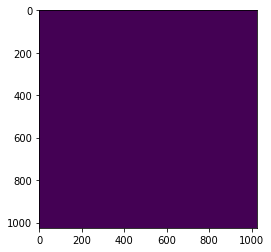

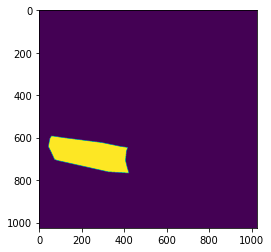

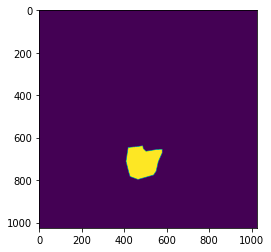

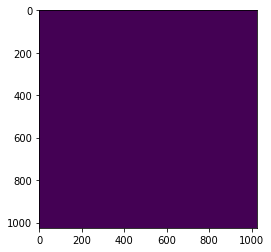

In [15]:
one_zeros = np.zeros([1025, 1025])
two_zeros = np.zeros([1025, 1025])
three_zeros = np.zeros([1025, 1025])
four_zeros = np.zeros([1025, 1025])

for id, array in zip(id_list, array_list):
    if id == 1: one_zeros += array
    elif id == 2: two_zeros += array
    elif id == 3: three_zeros += array
    elif id == 4: four_zeros += array

plt.imshow(one_zeros)
plt.show()
plt.imsave(img_path+f'mask/1/b_000.jpg', one_zeros, cmap = 'gray')

plt.imshow(two_zeros)
plt.show()
plt.imsave(img_path+f'mask/2/b_000.jpg', two_zeros, cmap = 'gray')

plt.imshow(three_zeros)
plt.show()
plt.imsave(img_path+f'mask/3/b_000.jpg', three_zeros, cmap = 'gray')

plt.imshow(four_zeros)
plt.show()
plt.imsave(img_path+f'mask/4/b_000.jpg', four_zeros, cmap = 'gray')

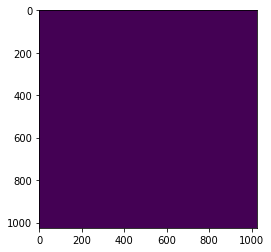

In [80]:
plt.imshow(four_zeros)

In [58]:
test_list = [1, 1, 1, 2, 1, 3, 2, 1]

In [59]:
test_list.count(1)

5

In [66]:
test_dic = {1 : 11,
            1 : 22}

In [68]:
test_dic

{1: 22}

In [ ]:
dataset.image_info

In [64]:
all_mask_data = {}
for d in dataset.image_info:
    all_mask_data[d['id']] = {}

In [ ]:
classes = dataset.class_info

for i, data in dataset.image_info:
    w = data['width'] + 1
    h = data['height'] + 1
    print('--------------------------', data['id'], '--------------------------')
    for idx, (poly, ids) in enumerate(zip(data['polygons'], data['num_ids'])):
        
        
        zeros_mask = np.zeros([h, w])
        
        x = poly['all_points_x']
        y = poly['all_points_y']
        
        poly_x, poly_y = skimage.draw.polygon(x, y)
        
        print(classes[ids]['id'], classes[ids]['name'])
        
        for px, py in zip(poly_x, poly_y):
            zeros_mask[py, px] = 1
        plt.imshow(zeros_mask)
        plt.show()

In [35]:
a = [4,5,2,1]

alist = [(i,j) for i in a for j in range(5) ]
alist



[(4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4)]